In [42]:
from Column import Column
from Condition import Condition
from Table import Table
from Query import Query
#from Query import other

In [43]:
import pandas as pd

def compareColumns(q: Query, q_pred:list[Query]):
    best_distance = {"ADD":100_000,"REMOVE":100_000}
    total_best_distance = 200_000
    # Get words for column section
    original_columns = {c : True for c in q.columns}
    for query in q_pred:
        other_columns = {c : True for c in query.columns}
        current_distance = {"ADD":0,"REMOVE":0}
        # Get the distance between column sections
        for word_other in other_columns.keys():
            # Remove
            if word_other not in original_columns:
                current_distance["REMOVE"] += 1
                
        for word_other in original_columns.keys():    
            # Addition
            if word_other not in other_columns:
                current_distance["ADD"] += 1
        
        total_distance = current_distance["ADD"] + current_distance["REMOVE"]
        if total_distance < total_best_distance:
            total_best_distance = total_distance
            best_distance = current_distance
    
    return best_distance


def compareConditions(q:Query, q_pred: list[Query]):
    q_condition = q.condition
    q_condition_column = q_condition.column_name
    q_condition_operator = q_condition.logic_operator
    best_distance = {"ADD":100_000,"REMOVE":100_000}
    total_best_distance = 200_000
    
    for query in q_pred:
        if query.condition.is_empty() and q_condition.is_empty():
            return {"ADD":0,"REMOVE":0}
        if query.condition.is_empty() or q_condition.is_empty():
            return {"ADD":2,"REMOVE":2}
        current_operator = query.condition.logic_operator
        current_column = query.condition.column_name
        current_distance = {"ADD":0,"REMOVE":0}
        if q_condition_column != current_column:
            current_distance["ADD"] += 1
            current_distance["REMOVE"] += 1
        if q_condition_operator != current_operator:
            current_distance["ADD"] += 1
            current_distance["REMOVE"] += 1
        total_distance = current_distance["ADD"] + current_distance["REMOVE"]
        if total_distance < total_best_distance:
            total_best_distance = total_distance
            best_distance = current_distance
        
    
    return best_distance


def compareTables(q:Query, q_pred: list[Query]):
    table_results = []
    best_distance = {"ADD":100_000,"REMOVE":100_000}
    total_best_distance = 200_000
    
    for query in q_pred:
        current_distance = {"ADD":0,"REMOVE":0}

        if query.table != q.table:
            current_distance["ADD"] += 1
            current_distance["REMOVE"] += 1
        
        total_distance = current_distance["ADD"] + current_distance["REMOVE"]
        if total_distance < total_best_distance:
            total_best_distance = total_distance
            best_distance = current_distance
    
    return best_distance


In [44]:
original_queries_path = "../../data/processed/equivalent_queries.pkl"
generated_queries_path = "./predicted_queries.pkl"

In [45]:
import pickle

f = open(generated_queries_path, "rb")
generated_queries = pickle.load(f)

generated_queries

[[<Query.Query at 0x297081f4d90>],
 [],
 [],
 [<Query.Query at 0x29708fb1c10>, <Query.Query at 0x2977fe350d0>],
 [],
 [],
 [],
 [<Query.Query at 0x297082a3110>, <Query.Query at 0x297082a0e10>],
 [<Query.Query at 0x297082a3550>, <Query.Query at 0x297090aef90>],
 [],
 [<Query.Query at 0x297090fed10>, <Query.Query at 0x297090ff810>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x29709108a50>, <Query.Query at 0x29709108850>],
 [],
 [],
 [<Query.Query at 0x2970912cbd0>, <Query.Query at 0x2970912d210>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x29709129410>, <Query.Query at 0x2970912a250>],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x2970912b450>, <Query.Query at 0x2970912b590>],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x297091330d0>, <Query.Query at 0x29709132510>],
 [<Query.Query at 0x29709133950>, <Query.Query at 0x29709133b10>],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Query.Query at 0x29709148610>, <Query

In [46]:
generated_queries[1]

In [47]:
import pandas as pd

def compare_queries(original_queries, generated_queries):
    columns_results = []
    conditions_results = []
    tables_results = []

    for original_query, generated_query in zip(original_queries, generated_queries):
        columns_results.append(compareColumns(original_query, generated_query))
        conditions_results.append(compareConditions(original_query, generated_query))
        tables_results.append(compareTables(original_query, generated_query))
    
    
    return columns_results, conditions_results, tables_results

# Cargar las consultas originales y generadas
original_queries = pd.read_pickle(original_queries_path)
generated_queries = pd.read_pickle(generated_queries_path)

# Comparar las consultas
columns_results, conditions_results, tables_results = compare_queries(original_queries, generated_queries)



AttributeError: 'Axes' object has no attribute 'xlabel'

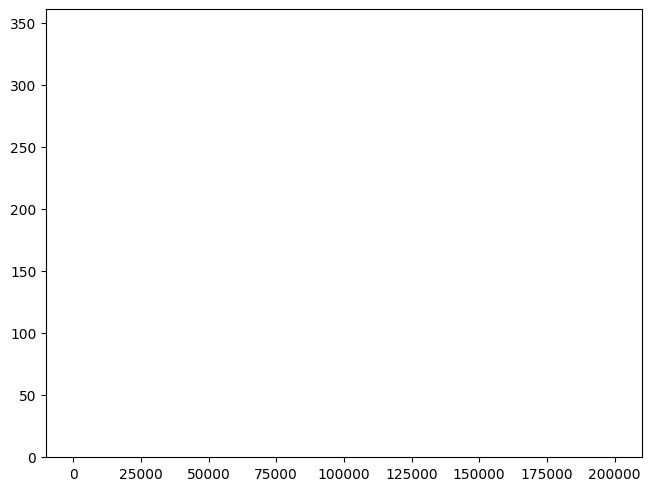

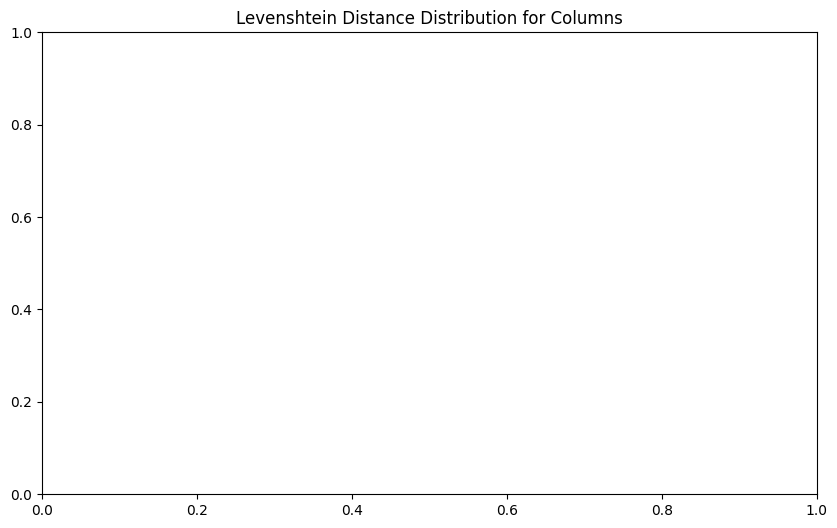

In [57]:
import numpy as np
import matplotlib.pyplot as plt

# Función para graficar las distribuciones de distancias
def plot_distance_distribution(distances: list[dict], title, x_label='Levenshtein Distance'):
    freq = {}
    for distance in distances:
        total_distance = distance["ADD"] + distance["REMOVE"]
        if total_distance not in freq:
            freq[total_distance] = 0
        freq[total_distance] += 1
    max_freq = max(freq, key=freq.get)
    distances = sorted(distances, key=lambda item: item["ADD"] + item["REMOVE"])
    fig, ax = plt.subplots(layout='constrained')
    freq_dist = []
    
    ax.bar(freq.keys(), freq.values())
    # ax.barh(range(len(distances)), distances)
    # for v in distances:
    #     rects = ax.bar(v["ADD"],v["REMOVE"], label = )
    #     ax.bar_label(rects, padding=3)
    plt.figure(figsize=(10, 6))
    plt.title(title)
    # ax.xlabel(x_label)
    ax.set_ylabel('Frequency')
    plt.show()

# Graficar las distribuciones de distancias
plot_distance_distribution(columns_results, 'Levenshtein Distance Distribution for Columns')
plot_distance_distribution(conditions_results, 'Levenshtein Distance Distribution for Conditions', 'Levenshtein Distance (Conditions Attributes)')
plot_distance_distribution(tables_results, 'Levenshtein Distance Distribution for Tables')


In [ ]:
original_queries[0].condition

In [ ]:
generated_queries[0].table